In [1]:
import csv
import numpy as np

f = open("placement_data_to_use.csv", newline='')
placement_train = open("placement_train.csv", 'w',newline='')
placement_test = open("placement_test.csv", 'w',newline='')

reader = csv.reader(f)
train_writer = csv.writer(placement_train)
test_writer = csv.writer(placement_test)

for row in reader:
    
    if row[0] == "Date":
        train_writer.writerow(row)
        test_writer.writerow(row)
    else:
        
        if np.random.rand() < .8:
            train_writer.writerow(row)
        else:
            
            test_writer.writerow(row)
placement_train.close()
placement_test.close()
f.close()
        

In [30]:

import csv

def make_one_hot_csv(f, name):
    reader = csv.reader(f)
    reader = csv.reader(x.replace('\0', '') for x in f)
    write_file = open(name, 'w',newline='')
    writer = csv.writer(write_file)
    campaigns=[]
    countries=[]
    audiences=[]
    platforms=[]
    placements=[]
    devices=[]
    labels = [ "return","total investment"]
    for row in reader:
        
        if row[0] != 'Date':
            if not row[1] in campaigns:
                campaigns.append(row[1])
                
            if not row[5] in countries:
                countries.append(row[5])
                
            if not row[6] in audiences:
                audiences.append(row[6])
                
            if not row[7] in platforms:
                platforms.append(row[7])
                
            if not row[8] in placements:
                placements.append(row[8])
                
            if not row[9] in devices:
                devices.append(row[9])
                
    
    reader = csv.reader(x.replace('\0', '') for x in f)
    f.seek(0)
    for campaign in campaigns:
        labels.append(campaign)
    for country in countries:
        labels.append(country)
    for audience in audiences:
        labels.append(audience)
    
    for  platform in platforms:
        labels.append(platform)
    for  placement in placements:
        labels.append(placement)
    for devices in devices:
        labels.append(devices)
    
    writer.writerow(labels)
    for row in reader:
        
        if row[6] != '' and row[0]!= "Date" :
            one_hot = []
            if float(row[4])>0:
                one_hot.append(float(row[11])/float(row[4]))
            else:
                one_hot.append(float(row[11]))
            one_hot.append(float(row[10]))
            
            
            for campaign in campaigns:
                if row[1] == campaign:
                    one_hot.append(1)
                else:
                    one_hot.append(0)
            for country in countries:
                if row[5] == country:
                    one_hot.append(1)
                else:
                    one_hot.append(0)
            for audience in audiences:
                if row[6] == audience:
                    
                    one_hot.append(1)
                else:
                    one_hot.append(0)
            for platform in platforms:
                
                if row[7] == platform:
                    
                    one_hot.append(1)
                else:
                    one_hot.append(0)
            for placement in placements:
                if row[8] == placement:
                    one_hot.append(1)
                else:
                    one_hot.append(0)
            for device in devices:
                if row[9] == device:
                    one_hot.append(1)
                else:
                    one_hot.append(0)
            writer.writerow(one_hot)
                
    write_file.close()
   
placement_train = open("placement_train.csv",newline='')
placement_test = open("placement_test.csv",newline='')
make_one_hot_csv(placement_train, "placement_one_hot_train.csv")
make_one_hot_csv(placement_test, "placement_one_hot_test.csv")

In [31]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.kernel_ridge import KernelRidge
import cvxpy as cp
from cvxpy.atoms.affine.binary_operators import MulExpression
import csv

from matplotlib import pyplot as plt

f = open("placement_one_hot_train.csv", newline='')
reader = csv.reader(f)
x_learn=[]
y_learn=[]
t_learn=[]
day_learn=[]
for row in reader:
    x_vals=[]
    if row[1] != "total investment":
        
        for val in row[2:]:
            x_vals.append(float(val))
        if float(row[0])>0:
            t_learn.append(float(row[1]))
            x_learn.append(x_vals)
            y_learn.append(np.log(float(row[0])))
            day_learn.append(float(row[2]))
    else:
        features=row[2:]

features=np.array(features)
x_learn=np.array(x_learn)
t_learn_vec=np.array(t_learn)
t_learn=np.diag(t_learn)
y_learn=np.array(y_learn)
day_learn=np.array(day_learn)

f.close()

splt = np.array(range(len(y_learn)))
np.random.shuffle(splt)
    
x_train = x_learn[splt[0:int(0.8*len(y_learn))]]
t_train = np.diag(t_learn_vec[splt[0:int(0.8*len(y_learn))]])
y_train = y_learn[splt[0:int(0.8*len(y_learn))]]

x_val = x_learn[splt[int(0.8*len(y_learn)):]]
t_val = np.diag(t_learn_vec[splt[int(0.8*len(y_learn)):]])
y_val = y_learn[splt[int(0.8*len(y_learn)):]]


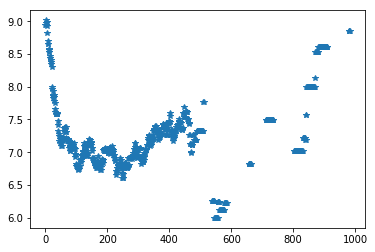

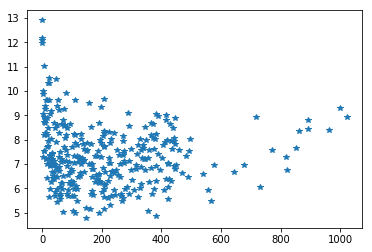

In [32]:

x_plot=[]
y_plot=[]
for i in range(1000):
    y_vals=[]
    
    for j in range(len(t_learn_vec)):
         
        if np.abs(i-t_learn_vec[j])<20:
            y_vals.append(y_learn[j])
    if len(y_vals)>1:
        x_plot.append(i)
        y_plot.append(np.mean(y_vals))

plt.plot(x_plot,y_plot,'*')
plt.show()
plt.plot(t_learn_vec,y_learn,'*')

In [33]:
#Constant
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def lin_model_MSE(t,y,w,b):
    return np.mean((np.dot(t,w)+b-y)**2)

w = cp.Variable(1)
b= cp.Variable(1)

objective = cp.Minimize(cp.sum_squares(y_train-b))

prob = cp.Problem(objective)
prob.solve()
w=np.array(w.value)
b=np.array(b.value)

print("Mean squared error")
print(np.mean((y_val-b)**2))

Mean squared error
1.930595233120266


In [34]:
#LINEAR REGRESION with  total investment
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def lin_model_MSE(t,y,w,b):
    return np.mean((np.dot(t,w)+b-y)**2)

w = cp.Variable(1)
b= cp.Variable(1)

objective = cp.Minimize(cp.sum_squares(y_train-MulExpression(np.diag(t_train),w)-b))

prob = cp.Problem(objective)
prob.solve()
w=np.array(w.value)
b=np.array(b.value)

print("Mean squared error")
print(lin_model_MSE(t_val,y_val,w,b))

Mean squared error
1.9249581220126428


In [35]:
#LINEAR REGRESION with poplulations and total investment
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def full_lin_model_MSE(x,t,y,w,b,inspt):
    return np.mean((np.dot(t,np.dot(x,w))+np.dot(x,b)+inspt-y)**2)
n=np.shape(x_learn)[1]
w = cp.Variable(n)
b= cp.Variable(n)
inspt = cp.Variable(1)
objective = cp.Minimize(cp.sum_squares(y_train-TPW(t_train, x_train, w)-MulExpression(x_train,b)-inspt))

prob = cp.Problem(objective)
prob.solve()
w=np.array(w.value)[:,0]
b=np.array(b.value)[:,0]
inspt = inspt.value
print("Mean squared error")
print(full_lin_model_MSE(x_val,t_val,y_val,w,b,inspt))

Mean squared error
8.710212534543274


In [77]:

#RIDGE REGRESION with poplulations and total investment
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def full_lin_model_MSE(x,t,y,w,slp,b,inspt):
    return np.mean((np.dot(t,np.dot(x,w))+np.diag(t)*slp+np.dot(x,b)+inspt-y)**2)
n=np.shape(x_train)[1]
w = cp.Variable(n)
b= cp.Variable(n)
insp=cp.Variable(1)
slp=cp.Variable(1)


best_err = -1
best_lam1 = 0
best_lam2 = 0
for i in range(100):
    lam1 = 1000*np.random.rand()
    lam2 = 1000*np.random.rand()
    objective = cp.Minimize(cp.sum_squares(y_train-TPW(t_train, x_train, w)-slp*np.diag(t_train)-MulExpression(x_train,b)-insp)
                            +lam1*cp.norm(w, p=2)**2+lam2*cp.norm(b, p=2)**2)

    prob = cp.Problem(objective)
    prob.solve()
    w_ar=np.array(w.value)[:,0]
    b_ar=np.array(b.value)[:,0]
    err=full_lin_model_MSE(x_val,t_val,y_val,w_ar,slp.value,b_ar,insp.value)
    if err < best_err or best_err < 0:
        best_lam1 = lam1
        best_lam2 = lam2
        best_err = err


print(best_lam1)
print(best_lam2)
print("Mean squared error")
print(best_err)


477.03868108448387
5.632259313094523
Mean squared error
1.7799750289086747


In [73]:

#ELASTIC NET with poplulations and total investment
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def full_lin_model_MSE(x,t,y,w,slp,b,inspt):
    return np.mean((np.dot(t,np.dot(x,w))+np.diag(t)*slp+np.dot(x,b)+inspt-y)**2)
n=np.shape(x_learn)[1]
w = cp.Variable(n)
b= cp.Variable(n)
insp=cp.Variable(1)
slpt=cp.Variable(1)



best_err = -1
best_lam1 = 0
best_lam2 = 0
best_lam3 = 0
best_lam4 = 0
for i in range(100):
    lam1 = 1000*np.random.rand()
    lam2 = 1000*np.random.rand()
    lam3 = 1000*np.random.rand()
    lam4 = 1000*np.random.rand()
    objective = cp.Minimize(cp.sum_squares(y_train-TPW(t_train, x_train, w)-slp*np.diag(t_train)-MulExpression(x_train,b)-insp)
                        +lam1*cp.norm(w, p=2)**2+lam2*cp.norm(b, p=2)**2+lam3*cp.norm(w, p=1)+lam4*cp.norm(b, p=1))

    prob = cp.Problem(objective)
    prob.solve()
    w_ar=np.array(w.value)[:,0]
    b_ar=np.array(b.value)[:,0]
    err=full_lin_model_MSE(x_val,t_val,y_val,w_ar,slp.value,b_ar,insp.value)
    if err < best_err or best_err < 0:
        best_lam1 = lam1
        best_lam2 = lam2
        best_lam3 = lam3
        best_lam4 = lam4
        best_err = err

print(best_lam1)
print(best_lam2)
print(best_lam3)
print(best_lam4)
print("Mean squared error")
print(best_err)


961.6798522866994
404.43778830927204
591.8473016719955
12.509866684811355
Mean squared error
1.8532704408368925


In [38]:

#LASSO REGRESION with poplulations and total investment
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def full_lin_model_MSE(x,t,y,w,slp,b,inspt):
    return np.mean((np.dot(t,np.dot(x,w))+np.diag(t)*slp+np.dot(x,b)+inspt-y)**2)

n=np.shape(x_train)[1]
w = cp.Variable(n)
b= cp.Variable(n)
insp=cp.Variable(1)
slp=cp.Variable(1)

splt = np.array(range(len(y_learn)))
np.random.shuffle(splt)


best_err = -1
best_lam1 = 0
best_lam2 = 0
for i in range(100):
   
    lam1 = 1000*np.random.rand()
    lam2 = 1000*np.random.rand()
    
    w = cp.Variable(n)
    b= cp.Variable(n)
    insp=cp.Variable(1)
    objective = cp.Minimize(cp.sum_squares(y_train-TPW(t_train, x_train, w)-slp*np.diag(t_train)-MulExpression(x_train,b)-insp)
                            +lam1*cp.norm(w, p=1)+lam2*cp.norm(b, p=1))

    prob = cp.Problem(objective)
    prob.solve()
    w_ar=np.array(w.value)[:,0]
    b_ar=np.array(b.value)[:,0]
    err=full_lin_model_MSE(x_val,t_val,y_val,w_ar,slp.value,b_ar,insp.value)
    
    if err < best_err or best_err < 0:
        best_lam1 = lam1
        best_lam2 = lam2
        best_err = err

print(best_lam1)
print(best_lam2)
print("Mean squared error")
print(best_err)


557.8743731386793
77.45630563806782
Mean squared error
1.8538740676347185


In [511]:
lam1=997.3378875385963
lam2=871.9914927586395
n=np.shape(x_train)[1]
w = cp.Variable(n)
b= cp.Variable(n)
insp=cp.Variable(1)
slp=cp.Variable(1)
objective = cp.Minimize(cp.sum_squares(y_train-TPW(t_train, x_train, w)-slp*np.diag(t_train)-MulExpression(x_train,b)-insp)
                            +lam1*cp.norm(w, p=1)+lam2*cp.norm(b, p=1))

prob = cp.Problem(objective)
prob.solve()

469.8769731971075

In [39]:
w_feature_filter=np.abs(np.array(w.value)[:,0])>10**-6
b_feature_filter=np.abs(np.array(b.value)[:,0])>10**-6

w_filtered_features = [features[i] for i in range(len(features)) if w_feature_filter[i]]
b_filtered_features = [features[i] for i in range(len(features)) if b_feature_filter[i]]
print(w_feature_filter)
print(b_feature_filter)
print(w_filtered_features)
print(b_filtered_features)

[False False False  True False  True False False False False False False
 False False False False False False False False False  True False False
  True False False False False False False False  True False False  True
 False  True  True  True False False  True  True  True  True False False
 False False False False False False False False False False False False
 False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
['US_RCH_Lookalikes_LeadGen', 'US_RCH_Outdoor_LeadGen', 'Lookalike (US, 2%) - rainfactoryS71C', 'Beachgoers + Parents w/ Young/Teenage Kids + Tech Adopters/Crowdfunding', 'Hiking Backpacking + CF Early Tech + Parent *1.4M', 'Mountain Biking + CF Early Te

In [74]:
w_filtered_x_train = x_train[:,w_feature_filter]
w_filtered_x_val = x_val[:,w_feature_filter]

b_filtered_x_train = x_train[:,b_feature_filter]
b_filtered_x_val = x_val[:,b_feature_filter]

#RIDGE REGRESION with poplulations and total investment filtered features
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def filtered_lin_model_MSE(w_x,t,y,w,slp,inspt):
    return np.mean((np.dot(t,np.dot(w_x,w))+np.diag(t)*slp+inspt-y)**2)
n=np.shape(w_filtered_x_train)[1]

w = cp.Variable(n)

insp=cp.Variable(1)
slp = cp.Variable(1)


best_err = -1
best_lam1 = 0
best_lam2 = 0
for i in range(100):
    lam1 = 1000*np.random.rand()
    
    errs=[]
        

    objective = cp.Minimize(cp.sum_squares(y_train-TPW(t_train, w_filtered_x_train, w)-slp*np.diag(t_train)-insp)
                            +lam1*cp.norm(w, p=2)**2)

    prob = cp.Problem(objective)
    prob.solve()
    w_ar=np.array(w.value)[:,0]
    
    err=filtered_lin_model_MSE(w_filtered_x_val,t_val,y_val,w_ar,slp.value,insp.value)
    
    if err < best_err or best_err < 0:
        best_lam1 = lam1
       
        best_err = err

print(best_lam1)

print("Mean squared error")
print(best_err)
print(w_feature_filter)

990.9871706884992
Mean squared error
1.8556076439709748
[False False False  True False  True False False False False False False
 False False False False False False False False False  True False False
  True False False False False False False False  True False False  True
 False  True  True  True False False  True  True  True  True False False
 False False False False False False False False False False False False
 False]


In [75]:
w_x_train = x_train[:,w_feature_filter]
w_x_val = x_val[:,w_feature_filter]


#ELASTIC NET  with poplulations and total investment filtereed features
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def filtered_lin_model_MSE(w_x,t,y,w,slp,inspt):
    return np.mean((np.dot(t,np.dot(w_x,w))+np.diag(t)*slp+inspt-y)**2)
n=np.shape(w_filtered_x_train)[1]
m=np.shape(b_filtered_x_train)[1]
w = cp.Variable(n)
b= cp.Variable(m)
insp=cp.Variable(1)
slp = cp.Variable(1)


best_err = -1
best_lam1 = 0
best_lam2 = 0
best_lam3 = 0
best_lam4 = 0
for i in range(100):
    
    lam1 = 1000*np.random.rand()
    lam2 = 1000*np.random.rand()
    lam3 = 1000*np.random.rand()
    lam4 = 1000*np.random.rand()
        

    objective = cp.Minimize(cp.sum_squares(y_train-TPW(t_train, w_x_train, w)-slp*np.diag(t_train)-insp)
                            +lam1*cp.norm(w, p=2)**2+lam3*cp.norm(w, p=1))

    prob = cp.Problem(objective)
    prob.solve()
    w_ar=np.array(w.value)[:,0]
    
    err=filtered_lin_model_MSE(w_x_val,t_val,y_val,w_ar,slp.value,insp.value)
    
    if err < best_err or best_err < 0:
        best_lam1 = lam1
        best_lam2 = lam2
        best_lam3 = lam3
        best_lam4 = lam4
        best_err = err

print(best_lam1)
print(best_lam2)
print(best_lam3)
print(best_lam4)
print("Mean squared error")
print(best_err)


770.3333620490554
580.0942480681707
380.50523325260986
548.5300209001807
Mean squared error
1.8504345946791236


m

In [48]:
w_filtered_x_train = x_train[:,w_feature_filter]
w_filtered_x_val = x_val[:,w_feature_filter]

b_filtered_x_train = x_train[:,b_feature_filter]
b_filtered_x_val = x_val[:,b_feature_filter]

#ELASTIC NET  with poplulations and total investment filtereed features huber loss
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def filtered_lin_model_MSE(w_x,t,y,w,slp,inspt):
    return np.mean((np.dot(t,np.dot(w_x,w))+np.diag(t)*slp+inspt-y)**2)
n=np.shape(w_filtered_x_train)[1]

w = cp.Variable(n)
b= cp.Variable(m)
insp=cp.Variable(1)
slp = cp.Variable(1)


best_err = -1
best_lam1 = 0
best_lam2 = 0
best_lam3 = 0
best_lam4 = 0
for i in range(100):
    
    lam1 = 1000*np.random.rand()
    lam2 = 1000*np.random.rand()
    lam3 = 1000*np.random.rand()
    lam4 = 1000*np.random.rand()
        

    objective = cp.Minimize(cp.sum_entries(cp.huber(y_train-TPW(t_train, w_x_train, w)-slp*np.diag(t_train)-insp))
                            +lam1*cp.norm(w, p=2)**2+lam3*cp.norm(w, p=1))

    prob = cp.Problem(objective)
    prob.solve()
    w_ar=np.array(w.value)[:,0]
    
    err=filtered_lin_model_MSE(w_x_val,t_val,y_val,w_ar,slp.value,insp.value)
    
    if err < best_err or best_err < 0:
        best_lam1 = lam1
        best_lam2 = lam2
        best_lam3 = lam3
        best_lam4 = lam4
        best_err = err

print(best_lam1)
print(best_lam2)
print(best_lam3)
print(best_lam4)
print("Mean squared error")
print(best_err)


438.9933938565739
805.2616119612709
45.42276953583346
361.2373259089726
Mean squared error
1.8805977193685723


In [50]:
w_filtered_x_train = x_train[:,w_feature_filter]
w_filtered_x_val = x_val[:,w_feature_filter]


#RIDGE REGRESION  with poplulations and total investment filtereed features huber loss
def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def filtered_lin_model_MSE(w_x,t,y,w,slp,inspt):
    return np.mean((np.dot(t,np.dot(w_x,w))+np.diag(t)*slp+inspt-y)**2)
n=np.shape(w_filtered_x_train)[1]

w = cp.Variable(n)

insp=cp.Variable(1)
slp = cp.Variable(1)


best_err = -1
best_lam1 = 0

for i in range(100):
    
    lam1 = 1000*np.random.rand()
    
        

    objective = cp.Minimize(cp.sum_entries(cp.huber(y_train-TPW(t_train, w_filtered_x_train, w)-slp*np.diag(t_train)-insp))
                            +lam1*cp.norm(w, p=2)**2)

    prob = cp.Problem(objective)
    prob.solve()
    w_ar=np.array(w.value)[:,0]
   
    err=filtered_lin_model_MSE(w_filtered_x_val,t_val,y_val,w_ar,slp.value,insp.value)
    
    if err < best_err or best_err < 0:
        best_lam1 = lam1
        
        best_err = err

print(best_lam1)

print("Mean squared error")
print(best_err)


418.46687791386194
Mean squared error
1.880191907856929


In [78]:
#The model with the best validation error was unfiltered ridge regresion

def TPW(t,p,w):
    return MulExpression(t,MulExpression(p,w))
def full_lin_model_MSE(x,t,y,w,slp,b,inspt):
    return np.mean((np.dot(t,np.dot(x,w))+np.diag(t)*slp+np.dot(x,b)+inspt-y)**2)

n=np.shape(x_train)[1]
w = cp.Variable(n)
b= cp.Variable(n)
insp=cp.Variable(1)
slp=cp.Variable(1)


lam1=477.03868108448387
lam2=5.632259313094523

insp=cp.Variable(1)
slp = cp.Variable(1)
objective = cp.Minimize(cp.sum_squares(y_train-TPW(t_train, x_train, w)-slp*np.diag(t_train)-MulExpression(x_train,b)-insp)
                            +lam1*cp.norm(w, p=2)**2+lam2*cp.norm(b, p=2)**2)

prob = cp.Problem(objective)
prob.solve()
w=np.array(w.value)[:,0]
b=np.array(b.value)[:,0]
slp=slp.value
insp=insp.value

err=full_lin_model_MSE(x_val,t_val,y_val,w,slp,b,insp)
print(err)

1.7799750289086747


In [79]:
demo_train = open("placement_train.csv", 'r',newline='')
demo_test = open("placement_test.csv", 'r',newline='')
demo_one_hot_train =open("placement_one_hot_train.csv", 'r',newline='')
demo_one_hot_test=open("placement_one_hot_test.csv", 'r',newline='')

corrected_demo_train = open("corrected_placement_train.csv", 'w',newline='')
corrected_demo_test = open("corrected_placement_test.csv", 'w',newline='')

reader = csv.reader(demo_train)
one_hot_reader = csv.reader(demo_one_hot_train)
writer = csv.writer(corrected_demo_train)

for row, one_hot_row in zip(reader, one_hot_reader):
    x=[]
    
    if row[0] != "Date":
        for val in one_hot_row[2:]:
            x.append(float(val))
        x=np.array(x)
        t=float(one_hot_row[1])
        row_to_write=row.copy()
       
        row_to_write[11]=float(row[11])/(np.exp(t*(np.dot(x,w)+slp)+np.dot(x,b)+insp))
        row_to_write.append(np.exp(t*(np.dot(x,w)+slp)+np.dot(x,b)+insp))
        writer.writerow(row_to_write)
    else:
        row[11]="return on investment"
        row.append("corection factor")
        writer.writerow(row)
demo_train.close()
corrected_demo_train.close()
demo_one_hot_train.close()

reader = csv.reader(demo_test)
one_hot_reader = csv.reader(demo_one_hot_test)
writer = csv.writer(corrected_demo_test)

for row, one_hot_row in zip(reader, one_hot_reader):
    x=[]
    if row[0] != "Date":
        for val in one_hot_row[2:]:
            x.append(float(val))
        x=np.array(x)
        t=float(one_hot_row[1])
        row_to_write=row.copy()
        
        row_to_write[11]=float(row[11])/(np.exp(t*(np.dot(x,w)+slp)+np.dot(x,b)+insp))
        row_to_write.append(np.exp(t*(np.dot(x,w)+slp)+np.dot(x,b)+insp))
        writer.writerow(row_to_write)
    else:
        row[11]="return on investment"
        row.append("corection factor")
        writer.writerow(row)
demo_test.close()
corrected_demo_test.close()
demo_one_hot_test.close()

In [536]:
np.dot(x,w)

array([0.])

In [473]:
best_lam1

497.2920342199895